# Beijing Pollution example

From: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

First example using preceding hour to predict current hour

Now import data and plot series

In [1]:
import numpy as np
import pandas as pd

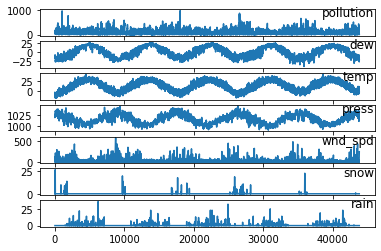

In [2]:
from matplotlib import pyplot
# load dataset
dataset = pd.read_csv('../datafiles/pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

Now convert the data to lagged variables. 

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [3]:
from pandas import concat
from pandas import DataFrame
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Now let's do all the preprocessing

In [4]:
 # Extract values to NumPy array
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')

Now we'll normalize the data to 0-1 range for training. Normally, we'd only normalize the features, but as we are going to use the PM2.5 value from the previous time step as an additional feature, we need to normalize this as well. As this means we will be modeling the normalized PM2.5 values, we'll store the minimum and maximum. This will allow us to back convert any predictions we make to parts per billion. 

In [5]:
values
pollution_min = np.min(values[:,0])
pollution_max = np.max(values[:,0])

print('PM2.5 Min: %.2f; Max: %.2f' % (pollution_min, pollution_max))

PM2.5 Min: 0.00; Max: 994.00


In [6]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [7]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [8]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


Now split into training/testing

In [9]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


## Dense network

In [10]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential([                        
      layers.Dense(50, input_shape=(8,)),
      layers.Dense(1)
])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                450       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [12]:
X_test.shape

(35039, 1, 8)

In [13]:
X_train_flat = X_train.reshape(8760, 8)
X_test_flat = X_test.reshape(35039, 8)

In [14]:
# fit network
history = model.fit(X_train_flat, y_train, epochs=50, batch_size=64, 
                    validation_data=(X_test_flat, y_test), verbose=2, shuffle=False)

Train on 8760 samples, validate on 35039 samples
Epoch 1/50
8760/8760 - 2s - loss: 0.0163 - mae: 0.0975 - val_loss: 0.0129 - val_mae: 0.1006
Epoch 2/50
8760/8760 - 1s - loss: 0.0036 - mae: 0.0451 - val_loss: 0.0107 - val_mae: 0.0902
Epoch 3/50
8760/8760 - 1s - loss: 0.0014 - mae: 0.0249 - val_loss: 0.0070 - val_mae: 0.0703
Epoch 4/50
8760/8760 - 1s - loss: 0.0011 - mae: 0.0186 - val_loss: 0.0048 - val_mae: 0.0573
Epoch 5/50
8760/8760 - 1s - loss: 0.0010 - mae: 0.0167 - val_loss: 0.0036 - val_mae: 0.0489
Epoch 6/50
8760/8760 - 1s - loss: 9.9241e-04 - mae: 0.0163 - val_loss: 0.0029 - val_mae: 0.0440
Epoch 7/50
8760/8760 - 1s - loss: 9.9139e-04 - mae: 0.0162 - val_loss: 0.0026 - val_mae: 0.0413
Epoch 8/50
8760/8760 - 1s - loss: 9.9292e-04 - mae: 0.0162 - val_loss: 0.0024 - val_mae: 0.0392
Epoch 9/50
8760/8760 - 1s - loss: 9.9618e-04 - mae: 0.0163 - val_loss: 0.0022 - val_mae: 0.0370
Epoch 10/50
8760/8760 - 1s - loss: 0.0010 - mae: 0.0164 - val_loss: 0.0020 - val_mae: 0.0352
Epoch 11/50
87

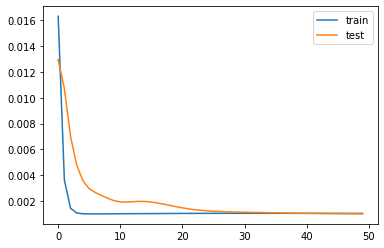

In [15]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [16]:
test_mse_score, test_mae_score = model.evaluate(X_test_flat, y_test, verbose=0)

In [17]:
print('Mean squared error: %.4f'
      % test_mse_score)
print('Mean absolute error: %.4f'
      % test_mae_score)

Mean squared error: 0.0010
Mean absolute error: 0.0212


MAE is based on normalized outcome. To back transform, we can use the min and max values of PM2.5 we stored earlier. First, we'll set up a small function that will back transform pollution values:

In [18]:
def back_transform(data, data_min=0, data_max=1):
    return (data * (data_max - data_min)) + data_min

Next, we need to get predictions for all of the test observations

In [19]:
y_test_pred_norm = model.predict(X_test_flat)
y_test_pred_norm.shape

(35039, 1)

The output of the `predict()` method is a 2D array, so we'll need to reshape this to a 1D array to match the observed PM2.5 values

In [20]:
y_test_pred_norm = y_test_pred_norm.reshape(y_test.shape)

Now we can back transform these predictions (and the observed PM2.5 values from the test set)

In [21]:
y_test_pred = back_transform(y_test_pred_norm, pollution_min, pollution_max)
y_test_obs = back_transform(y_test, pollution_min, pollution_max)

And finally, calculate the MAE in ppb:

In [22]:
np.mean(np.abs(y_test_pred - y_test_obs))

21.119453

## LSTM 

Now define the model

In [23]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential([                        
      layers.LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
      layers.Dense(1)
])

In [24]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________
None


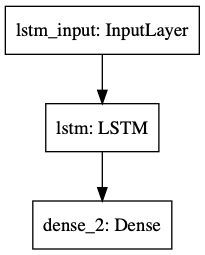

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [26]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Train model

In [27]:
# fit network
history = model.fit(X_train, y_train, epochs=50, batch_size=64, 
                    validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 8760 samples, validate on 35039 samples
Epoch 1/50
8760/8760 - 7s - loss: 0.0074 - mae: 0.0636 - val_loss: 0.0106 - val_mae: 0.0904
Epoch 2/50
8760/8760 - 3s - loss: 0.0045 - mae: 0.0488 - val_loss: 0.0130 - val_mae: 0.0996
Epoch 3/50
8760/8760 - 3s - loss: 0.0027 - mae: 0.0371 - val_loss: 0.0135 - val_mae: 0.0985
Epoch 4/50
8760/8760 - 3s - loss: 0.0017 - mae: 0.0286 - val_loss: 0.0119 - val_mae: 0.0905
Epoch 5/50
8760/8760 - 3s - loss: 0.0013 - mae: 0.0236 - val_loss: 0.0092 - val_mae: 0.0788
Epoch 6/50
8760/8760 - 3s - loss: 0.0011 - mae: 0.0205 - val_loss: 0.0069 - val_mae: 0.0682
Epoch 7/50
8760/8760 - 3s - loss: 0.0011 - mae: 0.0186 - val_loss: 0.0054 - val_mae: 0.0601
Epoch 8/50
8760/8760 - 3s - loss: 0.0010 - mae: 0.0175 - val_loss: 0.0044 - val_mae: 0.0544
Epoch 9/50
8760/8760 - 3s - loss: 9.9962e-04 - mae: 0.0169 - val_loss: 0.0038 - val_mae: 0.0502
Epoch 10/50
8760/8760 - 3s - loss: 9.8929e-04 - mae: 0.0165 - val_loss: 0.0034 - val_mae: 0.0470
Epoch 11/50
8760/8760 

Plot training history

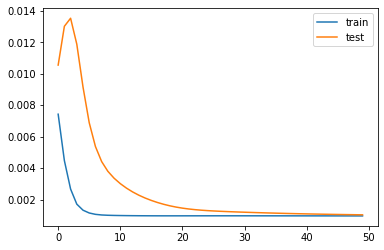

In [28]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Now predict for test set

In [29]:
test_mse_score, test_mae_score = model.evaluate(X_test, y_test, verbose=0)

In [30]:
print('Mean squared error: %.4f'
      % test_mse_score)
print('Mean absolute error: %.4f'
      % test_mae_score)

Mean squared error: 0.0010
Mean absolute error: 0.0201


Something here about difference between two models (~9% improvement)

In [31]:
y_test_pred_norm = model.predict(X_test)
y_test_pred_norm.shape

y_test_pred_norm = y_test_pred_norm.reshape(y_test.shape)

y_test_pred = back_transform(y_test_pred_norm, pollution_min, pollution_max)
y_test_obs = back_transform(y_test, pollution_min, pollution_max)

np.mean(np.abs(y_test_pred - y_test_obs))

20.004316

## Extending the model
Simple extension to use 3 previous time steps. New tensor shape is (?,3,8).

In [32]:
reframed = series_to_supervised(scaled, 3, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[25,26,27,28,29,30,31]], axis=1, inplace=True)
print(reframed.head())

   var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
3   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
4   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
5   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
6   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
7   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-3)  var8(t-3)  var1(t-2)  var2(t-2)  ...  var8(t-2)  var1(t-1)  \
3   0.000000        0.0   0.148893   0.367647  ...        0.0   0.159960   
4   0.000000        0.0   0.159960   0.426471  ...        0.0   0.182093   
5   0.000000        0.0   0.182093   0.485294  ...        0.0   0.138833   
6   0.037037        0.0   0.138833   0.485294  ...        0.0   0.109658   
7   0.074074        0.0   0.109658   0.485294  ...        0.0   0.105634   

   var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  var7(t-1)  \
3   0.426471   0.229508   0.545454   0.666667

Still define model in the same way

In [33]:
model = models.Sequential([                        
      layers.LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
      layers.Dense(1)
])

## Appendix

### Beijing pollution dataset: *pollution.csv*

| Column header | Variable |
| --- | --- |
| date | POSIX date (y-m-d h:m:s) |
| pollution | PM2.5 concentration (ppb) |
| dew | Dew point |
| temp | Temperature (C) |
| press | Air pressure (hPa) |
| wnd_dir | Wind direction (categorical) |
| wnd_spd | m s-1 |
| rain | mm |
